In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_columns = None

# Anonymisation

Here I anonymise the synethic dataset ([src](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTest.csv)). This notebook demonstrates (and justifies) the techniques used and applies them to a sample of the dataset. `anonymise.py` provides a single function which applies all these methods to a given file.


## TOC
 * [Preliminary](#Preliminary)
 * [Transaction Details](#Transaction-Details)
   * [Amount](#Amount)
   * [Time](#Time)
 * [Customer Details](#Customer-Details)
   * [Credit Card Number](#Credit-Card-Number)
   * [Personal Details](#Personal-Details)
 * [Merchant Details](#Merchant-Details)
 * [Location Details](#Location-Details)

In [3]:
# Load the data
training_data=pd.read_csv("data/synthetic_train.csv",index_col=0)
test_data=pd.read_csv("data/synthetic_train.csv",index_col=0)
full_data=pd.concat([training_data, test_data])

sample_df=full_data.sample(n=10)

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
print(full_data.shape)
full_data.dtypes

(2593350, 22)


trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [5]:
# Sample of the data
sample_df.head(n=10)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
102987,2019-03-01 09:24:50,4512828414983801773,fraud_Bogisich Inc,grocery_pos,55.59,Monica,Cohen,F,864 Reynolds Plains,Uledi,PA,15484,39.8936,-79.7856,328,Tree surgeon,1983-07-25,4c75164509c1996038b794a3c9f116e4,1330593890,39.352854,-80.118846,0
163005,2019-03-27 15:06:36,30103132002433,fraud_Weimann-Lockman,kids_pets,36.30,Stephanie,Middleton,F,99736 Rose Shoals Apt. 504,Morrisdale,PA,16858,41.0001,-78.2357,3688,Dispensing optician,1987-10-26,215f5a6725732a5620bd80722cc63a6a,1332860796,41.270838,-77.795668,0
655939,2019-10-06 14:36:51,345933964507467,fraud_Streich Ltd,home,19.22,Carol,Dillon,F,27479 Reeves Dale,Whaleyville,MD,21872,38.4121,-75.2811,718,Regulatory affairs officer,1985-03-19,9da66d9a3abebbc84e556c5274f7b143,1349534211,38.877581,-75.754398,0
1100197,2020-04-02 15:01:32,3596357274378601,"fraud_Nienow, Barrows and Romaguera",personal_care,6.39,David,Everett,M,4138 David Fall,Morrisdale,PA,16858,41.0001,-78.2357,3688,Advice worker,1973-05-27,bf5bfbf2dc19e9a2ba185949bdfc9fad,1364914892,41.649660,-78.174550,0
670078,2019-10-12 23:10:34,4170689372027579,fraud_Gislason Group,misc_pos,16.07,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,1993-05-10,df1c270d3c4d13152a359028416bc56e,1350083434,35.181141,-96.652803,0
1260600,2020-06-08 13:03:50,30487648872433,fraud_Lynch-Wisozk,home,172.66,Stephanie,Crane,F,144 Martinez Curve,Central,IN,47110,38.0970,-86.1723,350,Counsellor,1955-01-05,bbe3b4bb34fab31b83ac056edf01951d,1370696630,38.612231,-86.584117,0
1191,2019-01-01 14:13:46,375848982312810,fraud_Reilly LLC,home,41.46,Dale,Smith,M,25036 Contreras Turnpike Suite 270,Purmela,TX,76566,31.4841,-97.9903,258,Web designer,1943-12-15,3c4b96fa3bf98936098517ff94d3be91,1325427226,31.480463,-97.990718,0
938761,2020-01-09 12:40:22,180049032966888,"fraud_Schneider, Hayes and Nikolaus",food_dining,64.33,Michael,Flores,M,70761 Fitzpatrick Brooks Suite 631,Saxon,WI,54559,46.4959,-90.4383,795,Television/film/video producer,1986-04-15,d6de8db71d97a7c88828657616f76e5f,1357735222,46.138548,-91.355740,0
1256439,2020-06-07 08:43:19,4640395708703,fraud_Rodriguez Group,gas_transport,49.43,Melissa,Krause,F,67632 Martin Gateway,Fordoche,LA,70732,30.6576,-91.6264,1178,Community education officer,1951-06-13,dab27389cd58071e97b10d13a256d752,1370594599,29.687043,-91.156438,0
440080,2019-07-15 05:22:22,3511058278399773,"fraud_Bernier, Volkman and Hoeger",misc_net,13.16,Briana,Santos,F,702 Tabitha Drive,New Goshen,IN,47863,39.5803,-87.4616,205,"Engineer, mining",1960-01-06,64006097c4dfa9d13030c93a27d2ffb1,1342329742,40.449111,-86.752744,0


## Preliminary

Convert `trans_date_trans_time` and `dob` into `datetime` objects.

In [6]:
full_data["trans_date_trans_time"]=pd.to_datetime(full_data["trans_date_trans_time"],format="%Y-%m-%d %H:%M:%S")
full_data["dob"]=pd.to_datetime(full_data["dob"],format="%Y-%m-%d")

sample_df["trans_date_trans_time"]=pd.to_datetime(sample_df["trans_date_trans_time"],format="%Y-%m-%d %H:%M:%S")
sample_df["dob"]=pd.to_datetime(sample_df["dob"],format="%Y-%m-%d")

**Cleaned Data**

I define the dataframe `clean_df` which will hold all the prepared data

In [7]:
clean_df=pd.DataFrame()
clean_df["is_fraud"]=sample_df["is_fraud"]

## Transaction Details
 * `trans_date_trans_time`
 * `amt`
 * `trans_num`
 * `unix_time`
 * `is_fraud`
 
Leave `is_fraud` untouched as it is the feature we will be fitting the model to.

## Amount

In [8]:
clean_df["amt"]=sample_df["amt"].copy()

## Time

In the real data set time is given in seconds since the first transaction. I implement the function `standardise_time` which calculates the number of seconds between mid-night on the day of the first transaction and each transaction.

The full-time columns (`trans_date_trans_time` and `unix_time`) are still useful as you can use them to determine the year, month, day etc. of the transaction and thus may want to consider how to incorporate these into feature selection. 

In [9]:
def standardise_time(series) -> pd.Series:
    min_time=series.min().to_pydatetime()
    min_day=min_time.replace(second=0,minute=0,hour=0)
    return ((series-min_day).dt.total_seconds()).astype(int)

In [10]:
clean_df["unix_time"]=sample_df["unix_time"].copy()

## Customer Details

**Account Details**
 * `cc_num`
 
**Person Details**
 * `first`
 * `last`
 * `gender`
 * Address (`street`, `city`, `state`, `zip`, `lat`, `long`)
  * *Owen is working on this as we want to maintain relationships between locations*. (See [below](#Location-Details))
 * `job`
 * `dob`
 
**Other**
 * `city_pop`

### Credit Card Number

Anonymise credit card number

In [11]:
def anonymise(series:pd.Series) -> pd.Series:
    return series.astype("category").cat.codes

In [12]:
clean_df["cc_id"]=anonymise(sample_df["cc_num"])
clean_df.head(1)

,is_fraud,amt,unix_time,cc_id
102987,0,55.59,1330593890,9


### Personal Details

**Unique Person**

`first` and `last` contains the customers name, these need to be anonymised. I introduce the column `person_id` which contains a unique identifier for each person in the dataset (It is assumed each unique combination of `first`, `last`, `job` and `dob` is a unique person).

*Note* - Doing this means we cannot identify families, although we could only ever do this by assumption.

In [13]:
clean_df["person_id"]=anonymise(sample_df["first"]+"_"+sample_df["last"]+"_"+sample_df["job"]+"_"+sample_df["dob"].apply(lambda x: x.strftime('%Y-%m-%d')))

**Gender**

Keeping `gender` seems reasonable as it may be useful in the model fit. May be worth further investigation into whether there are notable differences in fraud rates/patterns between the genders.

In [14]:
clean_df["gender_id"]=anonymise(sample_df["gender"])

**Job**

The values supplied in `job` are very specific, however some do contain a categorisation which is given before a ",". This category can be easily extracted and helps cluster similar jobs (e.g. Engineering, Fitness, Doctors etc.)

In [15]:
full_data["job_cat"]=anonymise(full_data["job"].str.split(",").str[0].str.strip())
full_data["person_id"]=anonymise(full_data["first"]+"_"+full_data["last"]+"_"+full_data["job"]+"_"+full_data["dob"].apply(lambda x: x.strftime('%Y-%m-%d')))
print("Number of People in dataset = {}".format(full_data["person_id"].nunique()))

Number of People in dataset = 983


<AxesSubplot:>

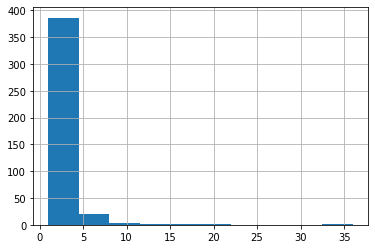

In [16]:
group_by=full_data[["person_id","job_cat"]].groupby(["job_cat"])
group_by["person_id"].nunique().hist() # histogram of number of people with each job title
# Suggest setting jobs with less than 5 people to None

In [17]:
def k_anon_jobs(df,k=2) -> pd.Series:
    """
    k anonymise jobs. Note -1 means a None value (Used for jobs which less than k people do)
    """
    df["job_category"]=anonymise(df["job"].str.split(",").str[0].str.strip())
    group_by=df[["person_id","job_category"]].groupby(["job_category"])
    rare_job_cats=np.where(group_by["person_id"].nunique()<k)[0].tolist()

    return df["job_category"].transform(lambda x:-1 if (x in rare_job_cats) else x)

clean_df["job_category"]=k_anon_jobs(pd.concat([sample_df["job"],clean_df["person_id"]],axis=1),k=2)
clean_df.head(5)

,is_fraud,amt,unix_time,cc_id,person_id,gender_id,job_category
102987,0,55.59,1330593890,9,6,0,-1
163005,0,36.30,1332860796,1,9,0,-1
655939,0,19.22,1349534211,4,1,0,-1
1100197,0,6.39,1364914892,7,3,1,-1
670078,0,16.07,1350083434,8,7,1,-1


**Date of Birth**

`dob` should be useful for the model, I am going to discretise this data into the age of the customer at the time of the transaction.

In [18]:
def dob_to_age(df) -> pd.Series:
    return (df["trans_date_trans_time"]-df["dob"])//np.timedelta64(1,"Y")

In [19]:
clean_df["age"]=dob_to_age(sample_df[["dob","trans_date_trans_time"]])

**City Population**

Intuitively it seems likely that `city_pop` may be useful in fitting the model as fraudsters may targer larger/smaller cities. Clustering the `city_pop` value seems a reasonable approach.

`k_anon_clustering` implements a naive algorithm for clustering `city_pop` values whilst ensuring `k`-anonimity. Cities with the same population will be in the same cluster. Note - `k` is the minimum size of each cluster and the greater the cluster id the greater the population size.

In [20]:
# k-anonymous clustering
def k_anon_clustering(series,k=2) -> pd.Series:
    series=series.copy()
    pop_vals=series.unique().tolist()
    pop_vals=pd.Series(pop_vals,pop_vals)
    pop_vals.sort_values(ascending=False,inplace=True)
    
    bin_id=0
    i=0
    for i in range(0,pop_vals.size-k+1,k):
        pop_vals[i:i+k]=bin_id
        if (i+2*k>pop_vals.size): pop_vals[i+k:]=bin_id # avoid underfull final bin
        bin_id+=1
    
    return series.transform(lambda x:pop_vals[x])

clean_df["city_pop_cluster_id"]=k_anon_clustering(sample_df["city_pop"],k=3)

In [21]:
clean_df.head(5)

,is_fraud,amt,unix_time,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id
102987,0,55.59,1330593890,9,6,0,-1,35,2
163005,0,36.30,1332860796,1,9,0,-1,31,0
655939,0,19.22,1349534211,4,1,0,-1,34,1
1100197,0,6.39,1364914892,7,3,1,-1,46,0
670078,0,16.07,1350083434,8,7,1,-1,26,0


## Merchant Details
 * `merchant`
 * `category`
 * Location (`merch_lat`,`merch_long`)
   * *Owen is working on this as we want to maintain relationships between locations*. (See [below](#Location-Details))

`merchant` is the name of the merchant and should be anonymised. This is done by simple converting it into an id.

In [22]:
clean_df["merchant_id"]=anonymise(sample_df["merchant"])

`category` is the verbose category of the merchant. This does not necessarily need to be anonymised as it is not identifiable, but some pre-processing should be performed in order to reduce the degrees of freedom of the model.

In [23]:
clean_df["merchant_category"]=sample_df["category"]

In [24]:
clean_df.head(5)

,is_fraud,amt,unix_time,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category
102987,0,55.59,1330593890,9,6,0,-1,35,2,1,grocery_pos
163005,0,36.30,1332860796,1,9,0,-1,31,0,9,kids_pets
655939,0,19.22,1349534211,4,1,0,-1,34,1,8,home
1100197,0,6.39,1364914892,7,3,1,-1,46,0,4,personal_care
670078,0,16.07,1350083434,8,7,1,-1,26,0,2,misc_pos


## Location Details

There is location data for customers (`street`, `city`, `state`, `zip`, `lat`, `long`) and for merchants (`merch_lat`,`merch_long`).

*Owen looked at this and chose the Maximum Distance to Average Vector (MDAV) algorithm, see `MDAV.py`. This was run on BC4 due to its long processing time.*

## Save File

In [25]:
clean_df

,is_fraud,amt,unix_time,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category
102987,0,55.59,1330593890,9,6,0,-1,35,2,1,grocery_pos
163005,0,36.30,1332860796,1,9,0,-1,31,0,9,kids_pets
655939,0,19.22,1349534211,4,1,0,-1,34,1,8,home
1100197,0,6.39,1364914892,7,3,1,-1,46,0,4,personal_care
670078,0,16.07,1350083434,8,7,1,-1,26,0,2,misc_pos
1260600,0,172.66,1370696630,2,8,0,-1,65,1,3,home
1191,0,41.46,1325427226,5,2,1,-1,75,2,5,home
938761,0,64.33,1357735222,3,5,1,-1,33,1,7,food_dining
1256439,0,49.43,1370594599,0,4,0,-1,68,0,6,gas_transport
440080,0,13.16,1342329742,6,0,0,-1,59,2,0,misc_net


In [26]:
def save_data(df:pd.DataFrame,file_path):
    df.to_csv(file_path)

In [27]:
# save_data("","data/prepared_syntheticg_data.csv")